In [1]:
%%time
import bayes3d as b

CPU times: user 4.59 s, sys: 5.09 s, total: 9.69 s
Wall time: 18.8 s


In [2]:
import numpy as np
import os
import jax
import jax.numpy as jnp
import trimesh
import time
import pickle
import bayes3d.transforms_3d as t3d
import bayes3d as b
import bayes3d as j
import bayes3d.meshcat
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import namedtuple


In [3]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


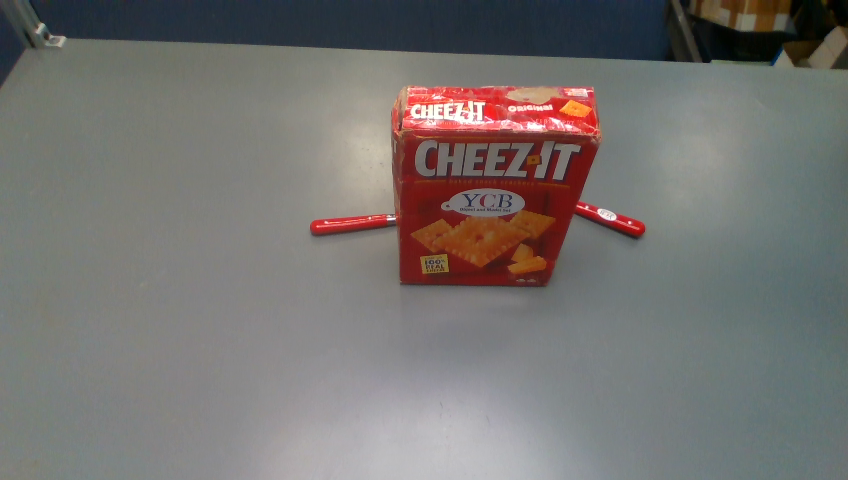

In [4]:
#test_pkl_file = os.path.join(b.utils.get_assets_dir(),"sample_imgs/cracker_sugar_banana_real.pkl.rgbds")
# test_pkl_file = os.path.join(b.utils.get_assets_dir(),"sample_imgs/strawberry_error.pkl.rgbds")
test_pkl_file = os.path.join(b.utils.get_assets_dir(),"sample_imgs/knife_spoon_box_real.pkl.rgbds")
with  open(test_pkl_file,'rb') as f:
    rgbds = pickle.load(f)
image = rgbds[0]
b.get_rgb_image(image.rgb)

In [5]:
!ls /home/nishadgothoskar/bayes3d/assets/sample_imgs/

ls: cannot access '/home/nishadgothoskar/bayes3d/assets/sample_imgs/': No such file or directory


In [6]:
import cv2

In [7]:
original_pc_image = b.t3d.unproject_depth_jit(image.depth, image.intrinsics)
scaling_factor = 0.3
intrinsics = b.camera.scale_camera_parameters(image.intrinsics, scaling_factor)

w,h = intrinsics.width, intrinsics.height
observed_point_cloud_image = jnp.array(cv2.resize(np.asarray(original_pc_image, dtype=original_pc_image.dtype), (w,h),interpolation=0).astype(original_pc_image.dtype))
print(intrinsics)

Intrinsics(height=144, width=254, fx=182.078613282, fy=181.955969238, cx=124.554812622, cy=77.66847839399999, near=0.001, far=5.0)


In [8]:
plane_pose, plane_dims = b.utils.find_plane_and_dims(observed_point_cloud_image.reshape(-1,3),
    ransac_threshold=0.001, inlier_threshold=0.001, segmentation_threshold=0.1
)
if plane_pose[:3,2][2] > 0:
    plane_pose = plane_pose @ t3d.transform_from_axis_angle(jnp.array([1.0, 0.0, 0.0]), jnp.pi)
b.clear()
b.show_cloud("1", observed_point_cloud_image.reshape(-1,3))
b.show_pose("2", plane_pose)

In [9]:
# mask = jnp.abs(b.t3d.apply_transform(observed_point_cloud_image, b.t3d.inverse_pose(plane_pose))[:,:,2])>0.01
# observed_point_cloud_image = observed_point_cloud_image * mask[...,None]
# b.get_depth_image(1.0*mask)

In [10]:
renderer = b.Renderer(intrinsics)
#model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models") #this line gives us the shape priors
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models_limited") # no cheez-it
#object 2 has been replaced by copy of object 1

# no shape acqusition yet, if we only have can, everything will stay a can
# not setting a likelihood threshold in the library for determining when a new shape is added to the library
# sugar box is specific and isn't even scale invariant - doing so would involve concept learning
# thus cheez-it box and sugar need to have different voxel occupancies

meshes = []
for idx in range(1,22):
    try:
        mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
        renderer.add_mesh_from_file(mesh_path,scaling_factor=1.0/1000.0)
    except:
        print('fail '+ str(idx))
SCALING_FACTOR = 3

table_mesh = j.mesh.make_cuboid_mesh(3*plane_dims)
renderer.add_mesh(table_mesh)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (256, 160, 512)


In [11]:
threedp3_likelihood_jit = jax.jit(jax.vmap(jax.vmap(
        j.threedp3_likelihood,
       in_axes=(None, None, None, 0, None, None)),
       in_axes=(None, 0, None, None, None, None)
), static_argnames=('filter_size',))


def score_trace(trace):
    reconstruction = renderer.render_multiobject(
        trace.poses , trace.ids
    )
    p = b.threedp3_likelihood_jit(
        trace.observation, reconstruction[:,:,:3],
        trace.variance, trace.outlier_prob, OUTLIER_VOLUME,
        5
    )
    return p

def render_image(trace):
    reconstruction = renderer.render_multiobject(
        trace.poses , trace.ids
    )
    return reconstruction

def score_traces(traces, renderer):
    reconstruction = renderer.render_multiobject_parallel(
        traces.all_poses , traces.ids
    )
    p = threedp3_likelihood_jit(
        traces.observation, reconstruction[:,:,:,:3],
        traces.variance, traces.all_outlier_prob, OUTLIER_VOLUME,
        5
    )
    return p


def viz_trace(trace):
    j.clear()
    key = jax.random.PRNGKey(10) # added
    b.show_cloud("1", trace.observation.reshape(-1,3))
    noisy_point_cloud_image = jax.random.multivariate_normal(
        key, trace.observation[:,:,:3].reshape(-1,3), jnp.eye(3)*trace.variance
    )
    b.show_cloud("2", noisy_point_cloud_image.reshape(-1,3), color=j.RED)

    colors = j.viz.distinct_colors(10)
    for i in range(len(trace.ids)):
        j.show_trimesh(f"obj_{i}", renderer.meshes[trace.ids[i]],color=colors[i])
        j.set_pose(f"obj_{i}", trace.poses[i])


Trace = namedtuple('Trace', ['poses', 'ids', 'variance', 'outlier_prob', 'observation'])
Traces = namedtuple('Traces', ['all_poses', 'ids', 'variance', 'all_outlier_prob', 'observation'])

In [12]:
VARIANCE = 0.00001
# VARIANCE_GRID = jnp.array([0.0001]).reshape(-1,1)
OUTLIER_GRID = jnp.linspace(0.01, 0.3, 3)
OUTLIER_VOLUME = 10.0**3

grid_params = [
    (0.2, jnp.pi, (11,11,11)), (0.1, jnp.pi/3, (11,11,11)), (0.1, jnp.pi/5, (11,11,1)),
    (0.0, jnp.pi, (1,1,11*11)), (0.05, jnp.pi/5, (11,11,11))
]
contact_param_gridding_schedule = [
    b.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params
]

contact_poses_jit = jax.jit(jax.vmap(b.scene_graph.relative_pose_from_edge, in_axes=(0,None, None)))


In [13]:
contact_plane = plane_pose
trace = Trace(
    plane_pose[None,...], [21],
    VARIANCE, 0.01,
    observed_point_cloud_image
)

# trace = Trace(
#     jnp.zeros((0,4,4)), [],
#     VARIANCE, 0.01,
#     observed_point_cloud_image
# )

In [16]:
for _ in range(3):
    all_traces = []
    for obj_id in tqdm(range(21)):
        contact_param = jnp.zeros(3)
        p = None
        traces = None
        for c2f_iter in range(len(contact_param_gridding_schedule)):
            contact_param_grid = contact_param_gridding_schedule[c2f_iter] + contact_param

            potential_new_object_poses = contact_plane @ contact_poses_jit(
                contact_param_grid,
                3,
                renderer.model_box_dims[obj_id],
            )

            potential_poses = jnp.concatenate(
                [
                    jnp.tile(trace.poses[:,None,...], (1,potential_new_object_poses.shape[0],1,1)),
                    potential_new_object_poses[None,...]
                ]
            )

            traces = Traces(
                potential_poses, trace.ids + [obj_id], trace.variance, OUTLIER_GRID, trace.observation
            )
            p = score_traces(traces, renderer)      

            ii,kk = jnp.unravel_index(p.argmax(), p.shape)
            contact_param = contact_param_grid[ii]

        best_trace = Trace(
            traces.all_poses[:,ii], traces.ids, traces.variance, traces.all_outlier_prob[kk], traces.observation
        )

        all_traces.append(
            best_trace
        )

    scores = jnp.array([score_trace(t) for t in all_traces])
    print(b.utils.normalize_log_scores(scores)) #print log probability
    order = jnp.argsort(-scores)
    print(order) #print ordering with highest first
    trace = all_traces[jnp.argmax(scores)]
    print(trace.ids)
    viz_trace(trace)


100%|██████████| 21/21 [00:09<00:00,  2.24it/s]


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[11 15 10  4  2  0  1  3  8 13 14 20  6 19  9 12  5  7 18 17 16]
[21, 15, 11]


100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[11  2  4  8  5  9  6  7 20 14 13 19  0  1 17 12  3 16 10 18 15]
[21, 15, 11, 11]


100%|██████████| 21/21 [00:10<00:00,  2.03it/s]


[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 2  4  3  8  6 16  7 18 13 14  9 10 17 19  0  1  5 12 20 15 11]
[21, 15, 11, 11, 2]


In [17]:
viz_trace(trace)

In [18]:
viz_trace(all_traces[9])

In [19]:
trace.outlier_prob

Array(0.155, dtype=float32)

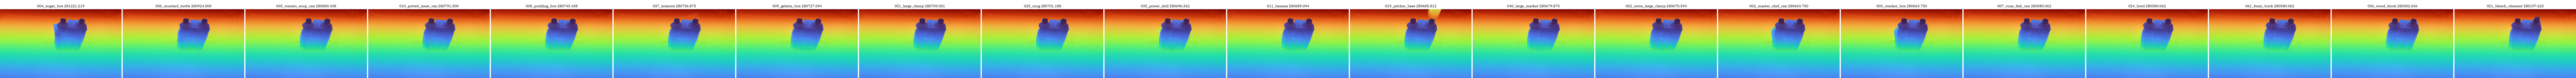

In [20]:

rendered_images = [render_image(t) for t in all_traces]

rgb_viz = j.scale_image(j.get_rgb_image(image.rgb),scaling_factor)
j.multi_panel(
    [j.scale_image(j.overlay_image(rgb_viz,j.get_depth_image(rendered_images[i][:,:,2]),0.9),4) for i in order],
    labels=["{:s} {:0.3f}".format(b.ycb_loader.MODEL_NAMES[i], scores[i]) for i in order]
)

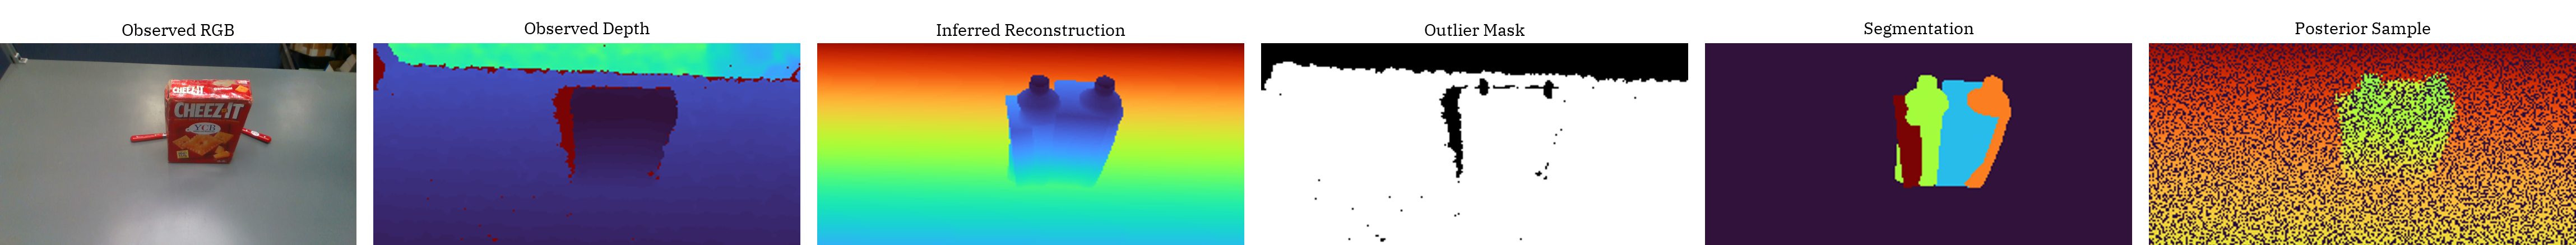

In [21]:

rgb = image.rgb
reconstruction = renderer.render_multiobject(
    trace.poses, trace.ids
)
inliers = (
    (jnp.log(1.0 - trace.outlier_prob)  + j.threedp3_likelihood_per_pixel(
        observed_point_cloud_image, reconstruction[:,:,:3], trace.variance, 0.0, 1.0, 3
    ))
        >
    jnp.log(trace.outlier_prob / OUTLIER_VOLUME)
)

rendered_seg = reconstruction[:,:,3]
j.get_depth_image(reconstruction[:,:,2])

variance = trace.variance
key = jax.random.PRNGKey(12)

noisy_point_cloud_image = jax.random.multivariate_normal(
    key, reconstruction[:,:,:3], jnp.eye(3)*variance, shape=reconstruction.shape[:2]
)
img = j.render_point_cloud(noisy_point_cloud_image.reshape(-1,3), intrinsics)
j.scale_image(j.get_depth_image(img[:,:,2]),10)

viz2 = j.multi_panel(
    [
        j.scale_image(j.get_rgb_image(rgb),SCALING_FACTOR/4),
        j.scale_image(j.get_depth_image(observed_point_cloud_image[:,:,2]), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(reconstruction[:,:,2]), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(1.0 *inliers,cmap=plt.cm.gray, min=0.0, max=1.0), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(reconstruction[:,:,3], max=5.0), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(img[:,:,2]), SCALING_FACTOR),
    ],
    labels=[
        "Observed RGB",
        "Observed Depth",
        "Inferred Reconstruction",
        "Outlier Mask",
        "Segmentation",
        "Posterior Sample",
    ],
    middle_width=30
)

viz2

In [22]:
noisy_point_cloud_image = jax.random.multivariate_normal(
    key, trace.observation[:,:,:3].reshape(-1,3), jnp.eye(3)*trace.variance
)

In [96]:
    noisy_point_cloud_image = jax.random.multivariate_normal(
        key, trace.observation[:,:,:3].reshape(-1,3), jnp.eye(3)*trace.variance, shape=trace.observation.reshape(-1,3).shape[0]
    )
    b.show_cloud("2", noisy_point_cloud_image.reshape(-1,3), color=j.RED)


[Array(0.205, dtype=float32),
 Array(0.205, dtype=float32),
 Array(0.205, dtype=float32),
 Array(0.205, dtype=float32),
 Array(0.205, dtype=float32),
 Array(0.205, dtype=float32),
 Array(0.205, dtype=float32),
 Array(0.205, dtype=float32),
 Array(0.205, dtype=float32),
 Array(0.205, dtype=float32),
 Array(0.205, dtype=float32),
 Array(0.205, dtype=float32),
 Array(0.205, dtype=float32),
 Array(0.205, dtype=float32),
 Array(0.205, dtype=float32),
 Array(0.205, dtype=float32),
 Array(0.205, dtype=float32),
 Array(0.205, dtype=float32),
 Array(0.205, dtype=float32),
 Array(0.205, dtype=float32),
 Array(0.205, dtype=float32)]

In [72]:
trace.variance

0.0001